paper: https://link.springer.com/article/10.1007/s11111-024-00452-9#Sec10

In [1]:
import os
import gc
import rasterio
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, osr
import dask_geopandas as dgpd
from rasterstats import zonal_stats

BASE_DIR = Path('/Users/wenlanzhang/PycharmProjects/Mapineq/src/')
DATA_DIR = Path('/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford')

In [17]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month
df["migration_month"] = pd.to_datetime(df["migration_month"])

# Define the mapping of old codes to new codes
country_code_mapping = {
    'GR': 'EL',  # Greece (GR → EL)
    'GB': 'UK'   # United Kingdom (GB → UK)
}

# Apply the replacement to both columns
df['country_from'] = df['country_from'].replace(country_code_mapping)
df['country_to'] = df['country_to'].replace(country_code_mapping)

df
# len(df['country_from'].unique())

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01-01,12,2019,1
1,AD,AE,2019-02-01,2,2019,2
2,AD,AE,2019-03-01,1,2019,3
3,AD,AE,2019-04-01,7,2019,4
4,AD,AE,2019-05-01,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138,2022,8
1563150,ZW,ZM,2022-09-01,162,2022,9
1563151,ZW,ZM,2022-10-01,149,2022,10
1563152,ZW,ZM,2022-11-01,104,2022,11


In [18]:
country_list = ['EL', 'ES', 'FI', 'FR', 'HR', 'EE', 'DE', 'DK', 'BA', 'AT', 'BG',
       'CH', 'CY', 'BE', 'CZ', 'AL', 'LU', 'LV', 'ME', 'IE', 'IS', 'IT',
       'MK', 'MT', 'LI', 'NL', 'LT', 'HU', 'RS', 'SE', 'SI', 'TR', 'UA',
       'SK', 'RO', 'NO', 'PL', 'PT', 'XK', 'UK']
# df = df[(df['country_from'].isin(country_list)) | (df['country_to'].isin(country_list))]
# df = df[(df['country_from'].isin(country_list)) & (df['country_to'].isin(country_list))]
df = df[(df['country_from'] == 'UA') & (df['country_to'].isin(country_list))]
df

,country_from,country_to,migration_month,num_migrants,year,month
1433801,UA,AL,2019-01-01,0,2019,1
1433802,UA,AL,2019-02-01,0,2019,2
1433803,UA,AL,2019-03-01,8,2019,3
1433804,UA,AL,2019-04-01,0,2019,4
1433805,UA,AL,2019-05-01,0,2019,5
...,...,...,...,...,...,...
1442052,UA,XK,2022-08-01,13,2022,8
1442053,UA,XK,2022-09-01,13,2022,9
1442054,UA,XK,2022-10-01,0,2022,10
1442055,UA,XK,2022-11-01,16,2022,11


In [19]:
# Step 1: Create unique flow ID (origin -> destination)
df["flow_id"] = df["country_from"] + "_" + df["country_to"]

# Create numeric indices for flows and months
df["flow_index"] = df["flow_id"].astype("category").cat.codes
df["time_index"] = (
    (df["migration_month"].dt.year - df["migration_month"].dt.year.min()) * 12 +
    (df["migration_month"].dt.month - df["migration_month"].dt.month.min())
)

# Check unique flow mappings and time indexing
flow_map = df[["flow_id", "flow_index"]].drop_duplicates().reset_index(drop=True)
time_range = df["migration_month"].min(), df["migration_month"].max()
df

/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_47476/2307499554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["flow_id"] = df["country_from"] + "_" + df["country_to"]
/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_47476/2307499554.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["flow_index"] = df["flow_id"].astype("category").cat.codes
/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_47476/2307499554.py:6: SettingWithCopyWarning: 
A value is trying to be set

,country_from,country_to,migration_month,num_migrants,year,month,flow_id,flow_index,time_index
1433801,UA,AL,2019-01-01,0,2019,1,UA_AL,0,0
1433802,UA,AL,2019-02-01,0,2019,2,UA_AL,0,1
1433803,UA,AL,2019-03-01,8,2019,3,UA_AL,0,2
1433804,UA,AL,2019-04-01,0,2019,4,UA_AL,0,3
1433805,UA,AL,2019-05-01,0,2019,5,UA_AL,0,4
...,...,...,...,...,...,...,...,...,...
1442052,UA,XK,2022-08-01,13,2022,8,UA_XK,37,43
1442053,UA,XK,2022-09-01,13,2022,9,UA_XK,37,44
1442054,UA,XK,2022-10-01,0,2022,10,UA_XK,37,45
1442055,UA,XK,2022-11-01,16,2022,11,UA_XK,37,46


In [38]:
# Your data:
flow_idx = df["flow_index"].values
time_idx = df["time_index"].values
y = df["num_migrants"].values
num_flows = df["flow_index"].nunique()
num_times = df["time_index"].nunique()

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=5)
    sigma_flow = pm.HalfNormal("sigma_flow", sigma=2)
    alpha = pm.Normal("alpha", mu=0, sigma=sigma_flow, shape=num_flows)
    sigma_time = pm.HalfNormal("sigma_time", sigma=2)
    beta = pm.Normal("beta", mu=0, sigma=sigma_time, shape=num_times)
    
    log_lambda = mu + alpha[flow_idx] + beta[time_idx]
    lambda_ = pm.math.exp(log_lambda)
    
    y_obs = pm.Poisson("y_obs", mu=lambda_, observed=y)

    trace = pm.sample(2000, tune=2000, target_accept=0.99, 
                      init='jitter+adapt_diag', chains=4, cores=4, max_treedepth=15, return_inferencedata=True)
    
    # trace = pm.sample(500, tune=500, chains=2, cores=2, target_accept=0.9)  # for simple test


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   4000    0             0.01        1023         18.32 draws/s    0:03:38   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   4000    0             0.00        1023         18.61 draws/s    0:03:34   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   4000    0             0.00        1023         24.43 draws/s    0:02:43   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   4000    0             0.00        511          24.20 draws/s    0:02:45   0:00:00

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 218 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


| Term            | Meaning                                                                    |
| --------------- | -------------------------------------------------------------------------- |
| **mean**        | Posterior mean (best guess based on all chains)                            |
| **sd**          | Posterior standard deviation (uncertainty)                                 |
| **hdi\_3%-97%** | 94% credible interval (Bayesian version of confidence interval)            |
| **r\_hat**      | Should be \~1.00. Values >1.1 → **non-converged** (⚠️ yours are too high)  |
| **ess\_bulk**   | Effective sample size. You want this to be **much higher** (like >200)     |
| **trace plots** | Chain mixing over time — your `mu` and `sigma_*` are **not well-mixed** 😕 |


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.904,0.308,4.346,5.537,0.095,0.055,11.0,26.0,1.27
sigma_flow,1.996,0.237,1.591,2.452,0.007,0.004,1426.0,3400.0,1.00
sigma_time,1.254,0.131,1.022,1.502,0.002,0.002,4370.0,4244.0,1.00


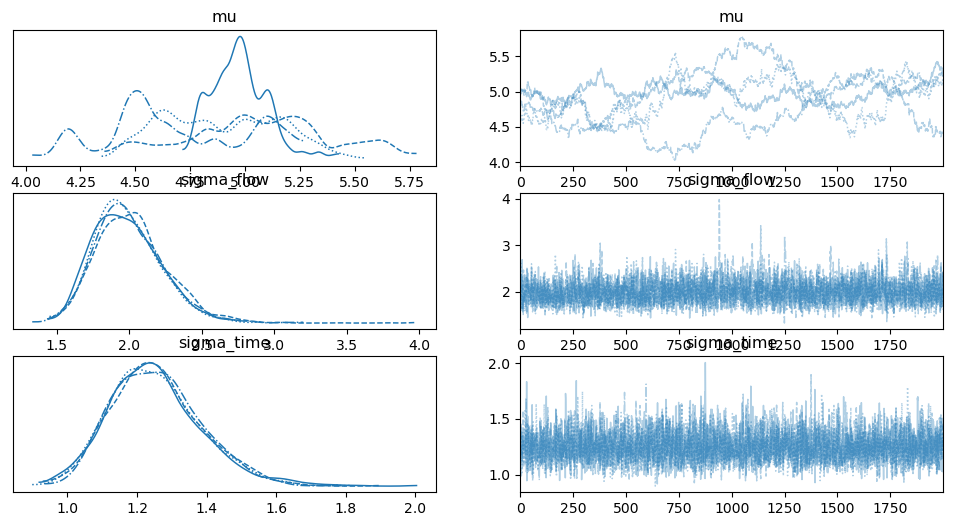

In [39]:
az.plot_trace(trace, var_names=["mu", "sigma_flow", "sigma_time"])
az.summary(trace, var_names=["mu", "sigma_flow", "sigma_time"])

In [64]:
# import numpy as np
# import arviz as az

# Extract posterior samples from trace
mu_samples = trace.posterior["mu"].values.flatten()
alpha_samples = trace.posterior["alpha"].values[:, :, 28].flatten()  # flow_index = 36 UK; 28 PL
beta_samples = trace.posterior["beta"].values[:, :, 38].flatten()    # time_index = 41

# Compute log-lambda samples
log_lambda_samples = mu_samples + alpha_samples + beta_samples

# Convert to rate (expected migrant count)
lambda_samples = np.exp(log_lambda_samples)

# Summary statistics
mean_prediction = lambda_samples.mean()
median_prediction = np.median(lambda_samples)
hdi_interval = az.hdi(lambda_samples, hdi_prob=0.94)

print(f"Estimated migrants from UA to UK in 2022-04:")
print(f"  Posterior mean: {mean_prediction:.2f}")
print(f"  Posterior median: {median_prediction:.2f}")
print(f"  94% credible interval: {hdi_interval[0]:.2f} to {hdi_interval[1]:.2f}")


Estimated migrants from UA to UK in 2022-04:
  Posterior mean: 33664.94
  Posterior median: 33664.09
  94% credible interval: 33458.36 to 33872.38


In [62]:
# df[(df['country_from'] == 'UA') & (df['country_to'] == 'PL')]
# df[(df['country_from'] == 'UA') & (df['country_to'] == 'UK')]
df[(df['flow_index'] == 28) & (df['time_index'] == 38)]

,country_from,country_to,migration_month,num_migrants,year,month,flow_id,flow_index,time_index
1439983,UA,PL,2022-03-01,34448,2022,3,UA_PL,28,38
